##### Contents<a id='Contents'></a>
  * [1 Part I - Exploratory Data Analysis](#Part_I)
  * [2 Part II - Experiment and metrics design](#Part_II)
  * [3 Part III - Prediction](#Part_III)      

## 1  Part I - Exploratory Data Analysis<a id='Part_I'></a>

Task:
Aggregrate the login data by 15 minute intervals.
Visualize and describe the results.

In [100]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [101]:
with open('logins.json', 'r') as json_file:
    json_logins = json.load(json_file)

In [102]:
logins = pd.DataFrame(json_logins)

In [103]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [104]:
logins.shape, logins.index, logins.columns

((93142, 1),
 RangeIndex(start=0, stop=93142, step=1),
 Index(['login_time'], dtype='object'))

In [105]:
logins.login_time = pd.to_datetime(logins.login_time)

In [106]:
logins.dtypes

login_time    datetime64[ns]
dtype: object

In [107]:
# create new dataframe, counts, with login counts every 15 minutes.
counts = logins.resample('15min', on='login_time').count()

In [108]:
counts.columns = ['Counts']

In [109]:
counts.tail()

,Counts
login_time,
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2
1970-04-13 18:30:00,7
1970-04-13 18:45:00,6


<AxesSubplot:xlabel='login_time'>

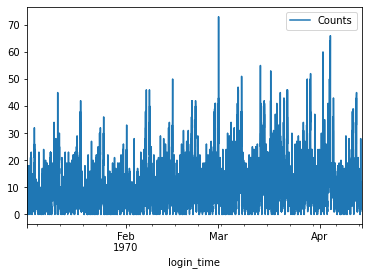

In [110]:
counts.plot()

It appears there is some increase in volume from February to April. Resample the data again every 14 days and count to see if this increase is real.

Results below show that volume consistently goes up from January and peaks mid-March. The next week volume goes down slightly and after that the data is incomplete.

In [111]:
counts_14days = logins.resample('14d', on='login_time').count()

In [112]:
counts_14days

,login_time
login_time,
1970-01-01,9166
1970-01-15,9883
1970-01-29,10455
1970-02-12,13144
1970-02-26,13976
1970-03-12,16511
1970-03-26,15024
1970-04-09,4983


To investigate the pattern of volume over a week, plots of one week in January, February, March, and April are shown below.

All days of the week show an afternoon and evening surge (which is showed more clearly in the analysis below). Highest volume occurs on Friday and Saturdays evenings when people go out for dining and events. All plots are Monday through Sunday, therefore, Friday and Saturday fall on the 16 and the 17 in January as an example.

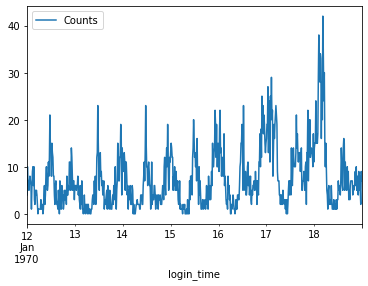

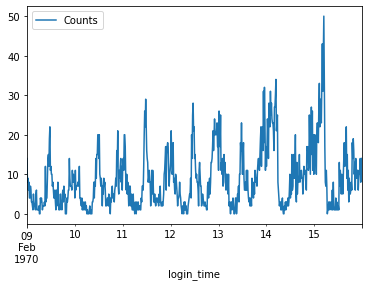

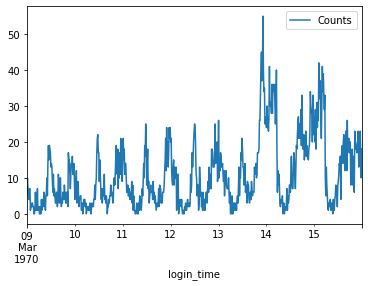

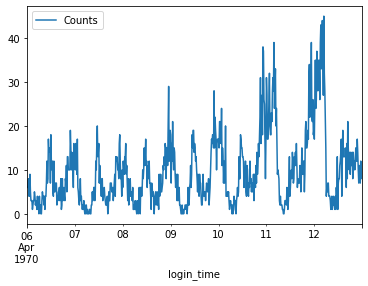

In [113]:
counts.loc[f'1970-01-12':f'1970-01-18'].plot()
counts.loc[f'1970-02-09':f'1970-02-15'].plot()
counts.loc[f'1970-03-09':f'1970-03-15'].plot()
counts.loc[f'1970-04-06':f'1970-04-12'].plot()

plt.show()

Plots of of one Wednesday and the following Saturday are overlayed for all four months. On Wednesdays (as with all weekdays), there is a clear surge around noon and a surge overnight that peaks around 11pm and then tapers off throughout the morning. Notably, there is not a surge for morning commuters. Presumably there is not a surge for evening commuters, though it's hard to tell because the everning surge begins right around 5pm.

As already noted, on Saturdays, there is heavy volume in the early morning hours along with surges in the afternoon and evening that usually outpaces the weekday volume.

In [114]:
# mondays and wednesdays in Jan, Feb, Mar, Apr

dates = (('1970-01-7',
         '1970-01-10'),
         ('1970-02-4',
         '1970-02-7'),
         ('1970-03-4',
         '1970-03-7'),
         ('1970-04-1',
         '1970-04-4'))

In [115]:
counts.head()

,Counts
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [116]:
wed = dates[0][0]
list(counts.loc[f'{wed} 00:00:00':f'{wed} 23:59:59'])

['Counts']

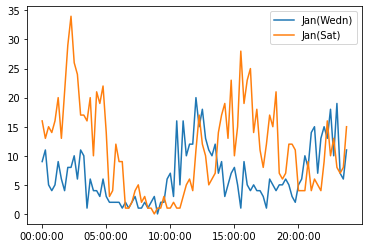

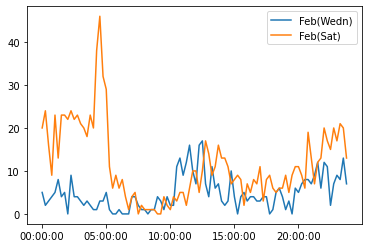

In [117]:
for month, (wed, sat) in [('Jan',(dates[0])),('Feb',(dates[1]))]:
#,('Mar',(dates[2])),('Apr',(dates[3]))]:
    index = [str(x.time()) for x in counts.loc[f'{wed} 00:00:00':f'{wed} 23:59:59'].index]
    days = pd.DataFrame({f'{month}(Wedn)':list(counts.loc[f'{wed} 00:00:00':f'{wed} 23:59:59','Counts']),
                  f'{month}(Sat)':list(counts.loc[f'{sat} 00:00:00':f'{sat} 23:59:59','Counts'])},index=index)
    
    days.plot()
    plt.show()

## 2  Part II - Experiment and metrics design<a id='Part_II'></a>

Background: Ultimate is proposing reimbursing drivers for tolls for the bridge that connects Metropolis to Gotham. Ultimate wants an experimental design to answer the question whether this will help encourage drivers to take customers in either city.

Question 1: Key metric of success

I propose as the key metric to determine if the policy is successful the average fees earned per driver per hour (with or without the reimbursement) minus any toll reimbursements. This metric will serve two purposes. First, if the policy is successful, drivers will be attracted to the customers (Metropolis during the day, and Gotham at night). Drivers with reimbursement will be able to find more customers relative to those without and therefore earn more. Therefore, the metric should detect the change in behavior. The second purpose is that by measuring the net extra fees earned, Ultimate will be able to determine if the reimbursement pays for itself with extra fees. 

Question 2a: Experimental design

Metropolis and Gotham drivers (based on home address or historical trips) will each be divided into two groups: an experimental group which gets the reimbursement and a control group which does not get it. The two cities will therefore represent two separate experiments that will be analyzed separately. All drivers will be operating on the same days, controlling for seasonal fluctuations, holidays, special events, etc.

A large number of observations is preferable as it provides the test with more power, that is the test can detect smaller differences. However, the company does not have time or budget to conduct the experiment for very long, and, fortunately, does not need to detect small differences anyway. Therefore an adequate number of observations can be determined beforehand based on a minimum difference that is needed to be detected--the smallest difference in fees earned that would justify reimbursing the bridge toll.

Question 2b: Statistical test

The experimental and control groups from each city will be compared pairwise. If there is a normal distribution of the fees earned per driver, then a two-sample t-test could be used to compare the average fees earned between the two groups. If the distribution is not normal, a permutation test will be used. In either case, the statistical question is whether the difference in fees earned between the experimental and control group cannot be explained by random chance.



Question 2c: Recommendations

After conducting the experiment for sufficient time to make enough observations for a meaningful statistical test, the results could be analyzed by the following criteria. If the test shows that the difference between drivers who receive the reimbursement and those that do not is not statistically significant, then the policy can be abandoned. If the difference is significant but too small to justify the reimbursement, then the policy could likewise be abandoned. If the difference is significant and adequately large, then the policy is a good idea and could be implemented.  

## 3  Part III - Prediction<a id='Part_III'></a>

Data Collection

In [118]:
with open('ultimate_data_challenge.json', 'r') as json_file:
    json_data = json.load(json_file)

In [119]:
data = pd.DataFrame(json_data)

In [120]:
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [121]:
data.shape

(50000, 12)

Exploratory Data Analysis

In [122]:
# make dates datetime dtype
data.signup_date = pd.to_datetime(data.signup_date)
data.last_trip_date = pd.to_datetime(data.last_trip_date)

In [123]:
# collect information about datatypes and missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

There are null values in three features: rating of driver, rating by driver, and phone type. These might be important in predictive modeling. Explore these features before decided to drop.

In [124]:
# collect basic statistics on numerical categories
data.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


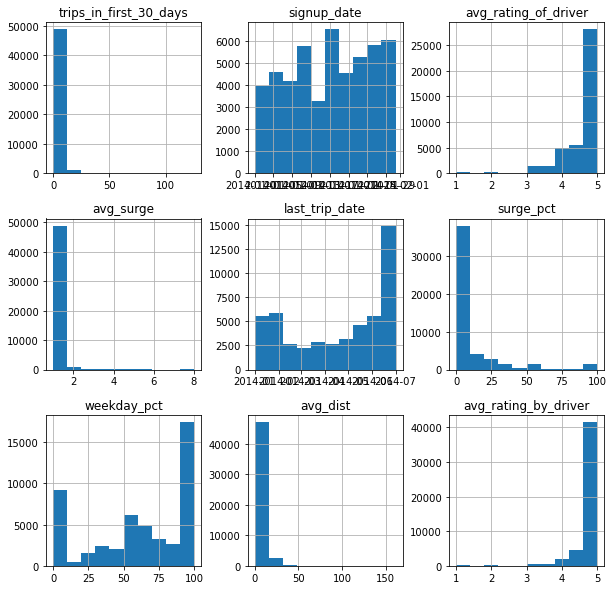

In [125]:
data.hist(figsize=(10,10))
plt.show()

In [126]:
# Verify that all signups are in January 2014.

data.signup_date.min(),data.signup_date.max() 

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-01-31 00:00:00'))

First, create active user category defined as taking a trip in last 30 days. 

In [127]:
# users who took a trip in June are 'active user'
data['Active User'] = data.last_trip_date > '2014-06-01 00:00:00'


In [128]:
data['Active User'].value_counts()

False    31690
True     18310
Name: Active User, dtype: int64

What percentage of users who signed up in January were active users after six months?

In [129]:
data['Active User'].mean()

0.3662

36% of the 50,000 users in data are active users

Visualize numerical categories further with violin plots dividing into categories active user and not active user. These plots show how well the category distinguishes active users.

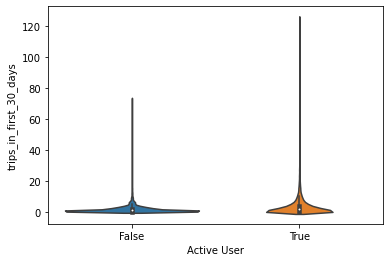

In [130]:
_ = sns.violinplot(x='Active User',y='trips_in_first_30_days',data=data)


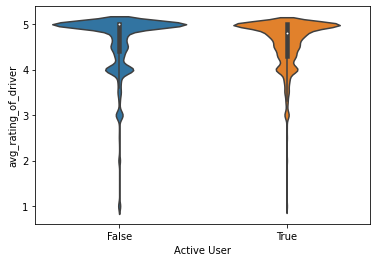

In [131]:
_ = sns.violinplot(x='Active User',y='avg_rating_of_driver',data=data)

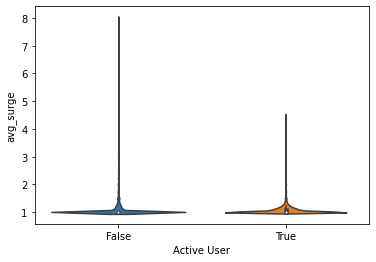

In [132]:
_ = sns.violinplot(x='Active User',y='avg_surge',data=data)

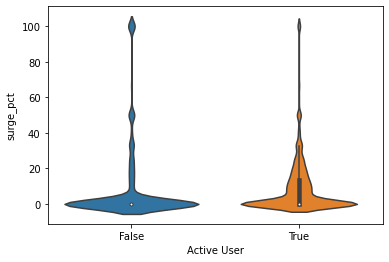

In [133]:
_ = sns.violinplot(x='Active User',y='surge_pct',data=data)

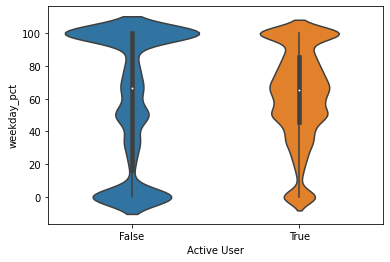

In [134]:
_ = sns.violinplot(x='Active User',y='weekday_pct',data=data)

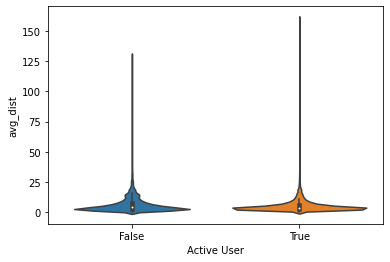

In [135]:
_ = sns.violinplot(x='Active User',y='avg_dist',data=data)

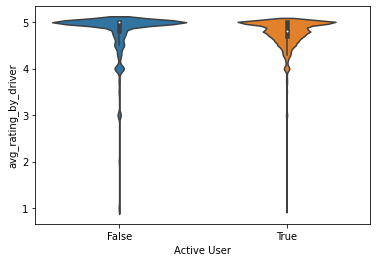

In [136]:
_ = sns.violinplot(x='Active User',y='avg_rating_by_driver',data=data)

It looks like non-active users are typically given a rating of 4 or 5, whereas, active users -- while still mostly getting ratings of 5 -- are far more likely to get a rating between 4 and 5.

To prepare data for modeling, categorical data should be encoded as dummy variables. There are three categorical features: city, phone, and active user (the target variable).

In [137]:
data.city.value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [138]:
data.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [139]:
data_dum = pd.get_dummies(data,drop_first=True)

In [140]:
data.shape, data_dum.shape

((50000, 13), (50000, 14))

In [141]:
# check new columns
data_dum.columns

Index(['trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'surge_pct', 'ultimate_black_user',
       'weekday_pct', 'avg_dist', 'avg_rating_by_driver', 'Active User',
       'city_King's Landing', 'city_Winterfell', 'phone_iPhone'],
      dtype='object')

Try model where ratings are imputed. Try second model where observations with missing ratings are dropped.

In [142]:
# most drivers and riders receive perfect ratings of 5
# therefore impute median rating to any missing ratings

driver_rate = data_dum.avg_rating_of_driver.median()
user_rate = data_dum.avg_rating_by_driver.median()
# 'avg_rating_of_driver', 'avg_rating_by_driver'
data_dum_impute = data_dum.fillna({'avg_rating_of_driver':driver_rate,'avg_rating_by_driver':user_rate})


In [143]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [144]:
# Split dataframe to X, y--train and test.
# drop last_trip_date since it is the basis for determining active user.
X = data_dum_impute.drop(['Active User','signup_date','last_trip_date'], axis=1)
y = data_dum_impute['Active User']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [145]:
rfc = RandomForestClassifier(
    max_depth=5,
    n_estimators=300, 
    random_state = 123, 
    n_jobs=-1)

In [146]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,recall_score,precision_score,log_loss

In [147]:
model_res = rfc.fit(X_train, y_train)
y_pred = model_res.predict(X_test)
y_pred_prob = model_res.predict_proba(X_test)
lr_probs = y_pred_prob[:,1]

ac = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Test Accuracy=%.3f' % (ac))
print('Random Forest: Test Precision=%.3f' % (prec))
print('Random Forest: Test Recall=%.3f' % (rec))
print(cm)
y_pred_train = model_res.predict(X_train)
train_ac = accuracy_score(y_train, y_pred_train)
train_rec = recall_score(y_train, y_pred_train)
train_prec = precision_score(y_train, y_pred_train)
print('Random Forest: Train Accuracy=%.3f' % (train_ac))
print('Random Forest: Train Precision=%.3f' % (train_prec))
print('Random Forest: Train Recall=%.3f' % (train_rec))

Random Forest: Test Accuracy=0.774
Random Forest: Test Precision=0.745
Random Forest: Test Recall=0.572
[[5660  711]
 [1553 2076]]
Random Forest: Train Accuracy=0.776
Random Forest: Train Precision=0.762
Random Forest: Train Recall=0.568


In [148]:
# drop missing ratings from data frame
# run model again 

data_dum_drop = data_dum.dropna()

In [149]:
data_dum_drop.shape

(41744, 14)

In [150]:
# Split dataframe to X, y--train and test.

X = data_dum_drop.drop(['Active User','signup_date','last_trip_date'], axis=1)
y = data_dum_drop['Active User']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [151]:
model_res = rfc.fit(X_train, y_train)
y_pred = model_res.predict(X_test)
y_pred_prob = model_res.predict_proba(X_test)
lr_probs = y_pred_prob[:,1]

ac = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Test Accuracy=%.3f' % (ac))
print('Random Forest: Test Precision=%.3f' % (prec))
print('Random Forest: Test Recall=%.3f' % (rec))
print(cm)
y_pred_train = model_res.predict(X_train)
train_ac = accuracy_score(y_train, y_pred_train)
train_rec = recall_score(y_train, y_pred_train)
train_prec = precision_score(y_train, y_pred_train)
print('Random Forest: Train Accuracy=%.3f' % (train_ac))
print('Random Forest: Train Precision=%.3f' % (train_prec))
print('Random Forest: Train Recall=%.3f' % (train_rec))

Random Forest: Test Accuracy=0.763
Random Forest: Test Precision=0.744
Random Forest: Test Recall=0.628
[[4256  727]
 [1251 2115]]
Random Forest: Train Accuracy=0.768
Random Forest: Train Precision=0.756
Random Forest: Train Recall=0.621


The model trained with data that drops missing values did better than when the data imputed missing values. The accuracy and precision were comparable but the recall was better.

In [152]:
from sklearn.model_selection import RandomizedSearchCV

In [153]:
# Number of trees in random forest
n_estimators = [20, 50, 100, 200, 300, 500]
# Number of features to consider at every split
max_features = ['sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 43, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 50]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 20]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Method of class balance
class_weight=['balanced','balanced_subsample',None]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight':class_weight}

In [154]:
run_tuning = False
if run_tuning:
    # Use the random grid to search for best hyperparameters
    rf = RandomForestClassifier()
    # Random search of parameters, using 5 fold cross validation, 
    # search across 200 different combinations
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring='recall', n_iter = 200, cv = 5, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(X_train,y_train)
    rf_random.best_params_

In [155]:
rf_random.best_params_

{'n_estimators': 300,
 'min_samples_split': 10,
 'min_samples_leaf': 20,
 'max_features': 'sqrt',
 'max_depth': 7,
 'class_weight': 'balanced',
 'bootstrap': True}

In [156]:
rfc = RandomForestClassifier(
    max_depth=7,
    min_samples_split=10,
    min_samples_leaf=20,
    max_features='sqrt',
    class_weight='balanced',
    bootstrap=True,
    n_estimators=300, 
    random_state = 123, 
    n_jobs=-1)
model_res = rfc.fit(X_train, y_train)
y_pred = model_res.predict(X_test)
y_pred_prob = model_res.predict_proba(X_test)
lr_probs = y_pred_prob[:,1]

ac = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Test Accuracy=%.3f' % (ac))
print('Random Forest: Test Precision=%.3f' % (prec))
print('Random Forest: Test Recall=%.3f' % (rec))
print(cm)
y_pred_train = model_res.predict(X_train)
train_ac = accuracy_score(y_train, y_pred_train)
train_rec = recall_score(y_train, y_pred_train)
train_prec = precision_score(y_train, y_pred_train)
print('Random Forest: Train Accuracy=%.3f' % (train_ac))
print('Random Forest: Train Precision=%.3f' % (train_prec))
print('Random Forest: Train Recall=%.3f' % (train_rec))

Random Forest: Test Accuracy=0.761
Random Forest: Test Precision=0.680
Random Forest: Test Recall=0.769
[[3767 1216]
 [ 779 2587]]
Random Forest: Train Accuracy=0.774
Random Forest: Train Precision=0.695
Random Forest: Train Recall=0.778


Model does considerably better after hyperparameter tuning.

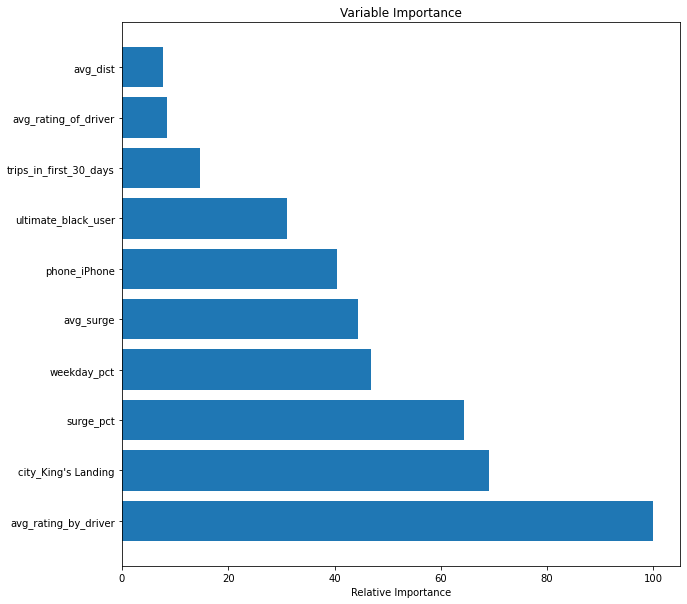

In [157]:
# find the best features

size=10
feature_importance = rfc.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
importance_unsorted = pd.DataFrame({'feature':X.columns,'importance':feature_importance})
importance_sorted = importance_unsorted.sort_values(by='importance',ascending=False)
pos = np.arange(size) + .5
plt.figure(figsize=(10,10))
plt.barh(pos, importance_sorted['importance'][:size], align='center')
plt.yticks(pos, importance_sorted['feature'][:size])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [158]:
# find mean of top features by active user status
data_dum_drop[['avg_rating_by_driver',"city_King's Landing",'surge_pct','Active User']].groupby('Active User').mean()

,avg_rating_by_driver,city_King's Landing,surge_pct
Active User,,,
False,4.788216,0.124201,8.738843
True,4.759350,0.342061,9.102810


In [159]:
# find median of top features by active user status
data_dum_drop[['avg_rating_by_driver',"city_King's Landing",'surge_pct','Active User']].groupby('Active User').median()

,avg_rating_by_driver,city_King's Landing,surge_pct
Active User,,,
False,5.0,0,0.0
True,4.8,0,2.7


Insights

Active users tend to be users who get more precise (and slightly lower) ratings from drivers, take more surge rides, and be based in King's Landing. They also tend to take more of a mix of weekend or weekday trips where non-active users take mainly one or the other. Notably, the ultimate black user status was a relatively unimportant factor.

As a result, the company can focus their efforts on attracting users outide of King's Landing, who take rides only on weekends or weekdays, take few surge rides, or usually get ratings of 5 from drivers.